<center>
    <h1> INF393 - Maquinas de Aprendizaje  </h1>
    <h2> Tarea 3: Métodos No Lineales para Clasificación </h2>
    <h5> Alumnos: Ignacio Espinoza & Daniel Rivera</h5>
</center>

<h2> PARTE 1: El Viejo XOR </h2>
<p> Para esta sección se analizarán distintos modelos lineales y no-lineales sobre un problema conocido en el mundo de máquinas de aprendizaje, el <i> XOR Problem </i>. Para ello primero necesitamos generar el dataset, en donde también se introducirá ruido a un sector específico de los datos.

<h3> Creación y Visualización de Dataset </h3>


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

def do_XOR( n = 1000 , noisy_n = 100, svm = True):
   rng = np.random.RandomState(0)
   X_train = rng.uniform( low = -1.0 , high = 1.0 , size = (n,2))

   Y_train = np.logical_xor( X_train[:,0] > 0 , X_train[:,1] > 0 )
   Y_train = 2*Y_train -1 if svm else Y_train

   X_noisy= rng.uniform( low = -0.8, high = 0.2, size=( noisy_n , 2 ) )
   
   Y_noisy = -1*np.logical_xor(X_noisy[:,0] > 0, X_noisy[:,1] > 0) + 1
   Y_noisy = 2*Y_noisy -1 if svm else Y_noisy

   X_train = np.vstack((X_train, X_noisy))
   Y_train = np.hstack((Y_train, Y_noisy))

   X_test = rng.uniform( low = -1.0 , high = 1.0, size = (n,2) )
   Y_test = np.logical_xor( X_test[:,0] > 0, X_test[:,1] > 0)
   Y_test = 2*Y_test - 1 if svm else Y_test

   return X_train,Y_train,X_test,Y_test

Using TensorFlow backend.


In [2]:
def plot_set(X,y,title):
   cmap = plt.cm.get_cmap('terrain')
   mclasses = (-1,1)
   mcolors = [cmap(i) for i in np.linspace(0,1,2)]
   plt.figure(figsize = (12,8))
   for lab, col in zip(mclasses,mcolors):
      plt.scatter(X[y == lab, 0] ,X[y == lab , 1], label = lab, c = col, s = 30)
   leg = plt.legend(loc= 'upper right', fancybox= True)
   plt.title(title)
   plt.show()

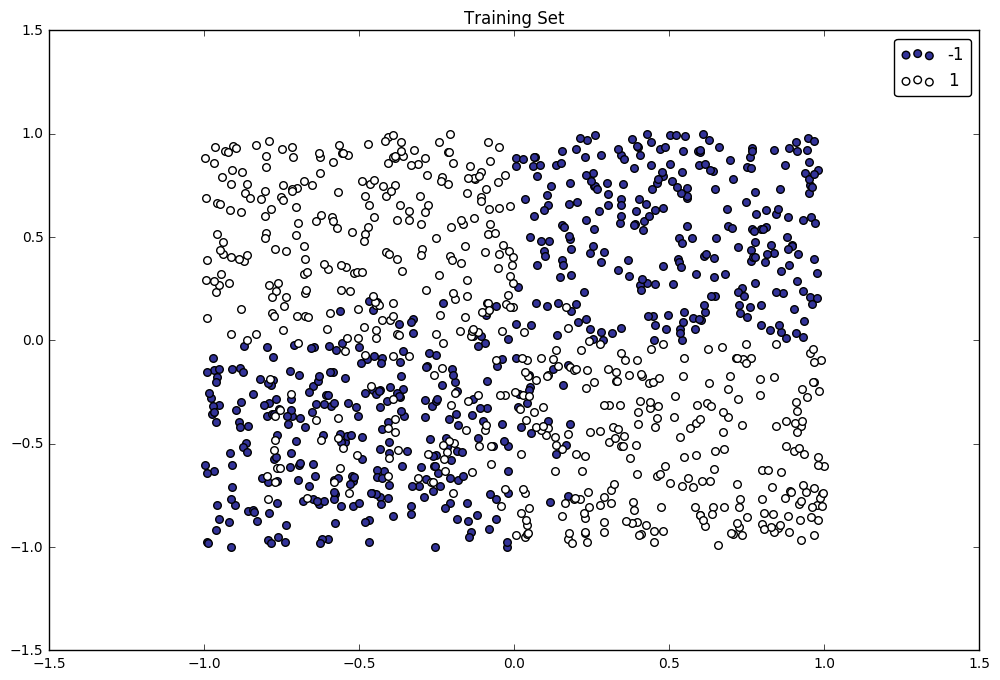

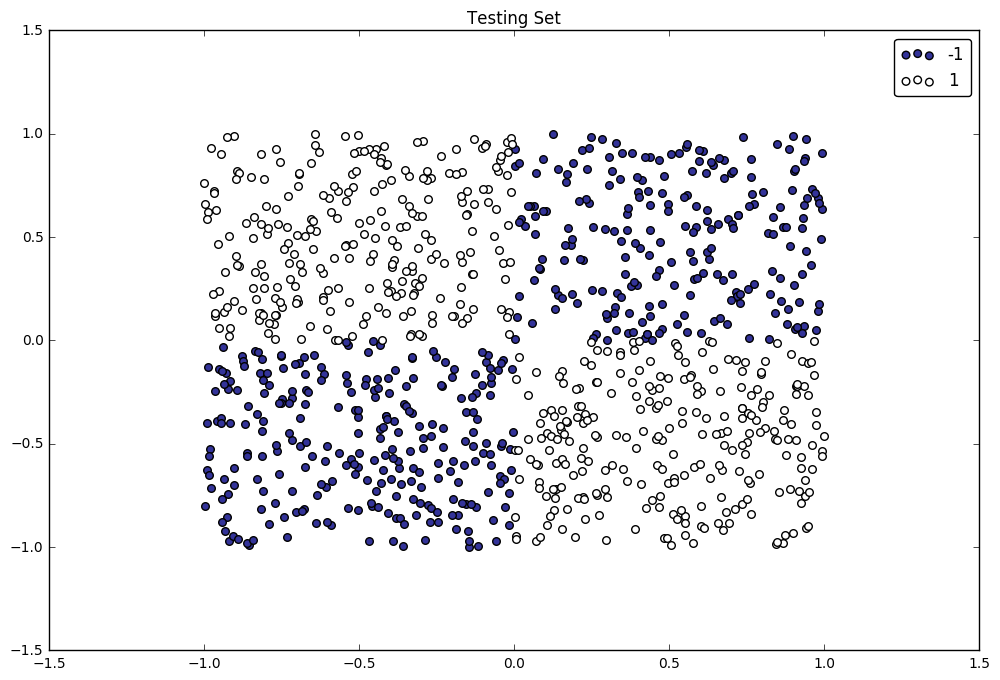

In [3]:
X_train,Y_train,X_test,Y_test = do_XOR()

plot_set(X_train,Y_train,"Training Set")

plot_set(X_test,Y_test,"Testing Set")

<p>Como se observa tanto en el set de entrenamiento como de prueba, hay una distribución uniforme de datos con 2 clases, de modo que la clasificación de estos datos asemeja al problema original de <b>XOR</b>, en donde hay una disyunción lógica, donde si un elemento posee tanto el eje $x$ y el eje $y$ del mismo signo (positivo o negativo) se la asigna la clase $-1$, y clase $1$ para el caso contrario.La característica mas importante es que ambas clases no pueden ser separadas con una linea recta simple. </p>

<table style="width:15%">
    <tr>
        <th>X</th>
        <th>Y</th>
        <th>Clase</th>
    </tr>
    <tr>
        <td>Positivo</td>
        <td>Positivo</td>
        <td>-1</td>
    </tr>
    <tr>
        <td>Negativo</td>
        <td>Negativo</td>
        <td>-1</td>
    </tr>
    <tr>
        <td>Positivo</td>
        <td>Negativo</td>
        <td>1</td>
    </tr>
    <tr>
        <td>Negativo</td>
        <td>Positivo</td>
        <td>1</td>
    </tr>
</table>

In [4]:
def plot_classifier(clf,X_train,Y_train,X_test,Y_test,model_type):
   f, axis = plt.subplots(1, 1, sharex = 'col', sharey = 'row', figsize = (15, 15))
   axis.scatter(X_train[:,0],X_train[:,1], s = 20, c = Y_train, zorder = 10,cmap = 'gray')
   axis.scatter(X_test[:,0],X_test[:,1], s = 20, c = Y_test, zorder = 10,cmap = 'gray')
   
   XX, YY = np.mgrid[-1:1:200j, -1:1:200j]

   if model_type == 'svm':
      Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
   elif model_type == 'tree':
      Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
   elif model_type == 'ann':
      Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
   else: raise ValueError('model type not supported')
   Z = Z.reshape(XX.shape)
   Zplot = Z > 0 if model_type == 'svm' else Z > 0.5
   
   axis.pcolormesh(XX, YY, Zplot , cmap = 'Blues')
   axis.contour(XX, YY, Z , alpha = 1 , colors= '#F44336', linestyles=['solid'], linewidths = 2, levels = [-1, 0, 1])
   plt.show()

def get_model_performance(clf,X_train,Y_train,X_test,Y_test,model_type):
   print clf.score(X_train,Y_train)
   print clf.score(X_test,Y_test)
   print classification_report(Y_test , clf.predict(X_test), target_names = ['-1','1'])

<h3> Análisis SVM Lineal </h3>

0.517272727273
0.471
             precision    recall  f1-score   support

         -1       0.46      0.47      0.46       489
          1       0.48      0.48      0.48       511

avg / total       0.47      0.47      0.47      1000



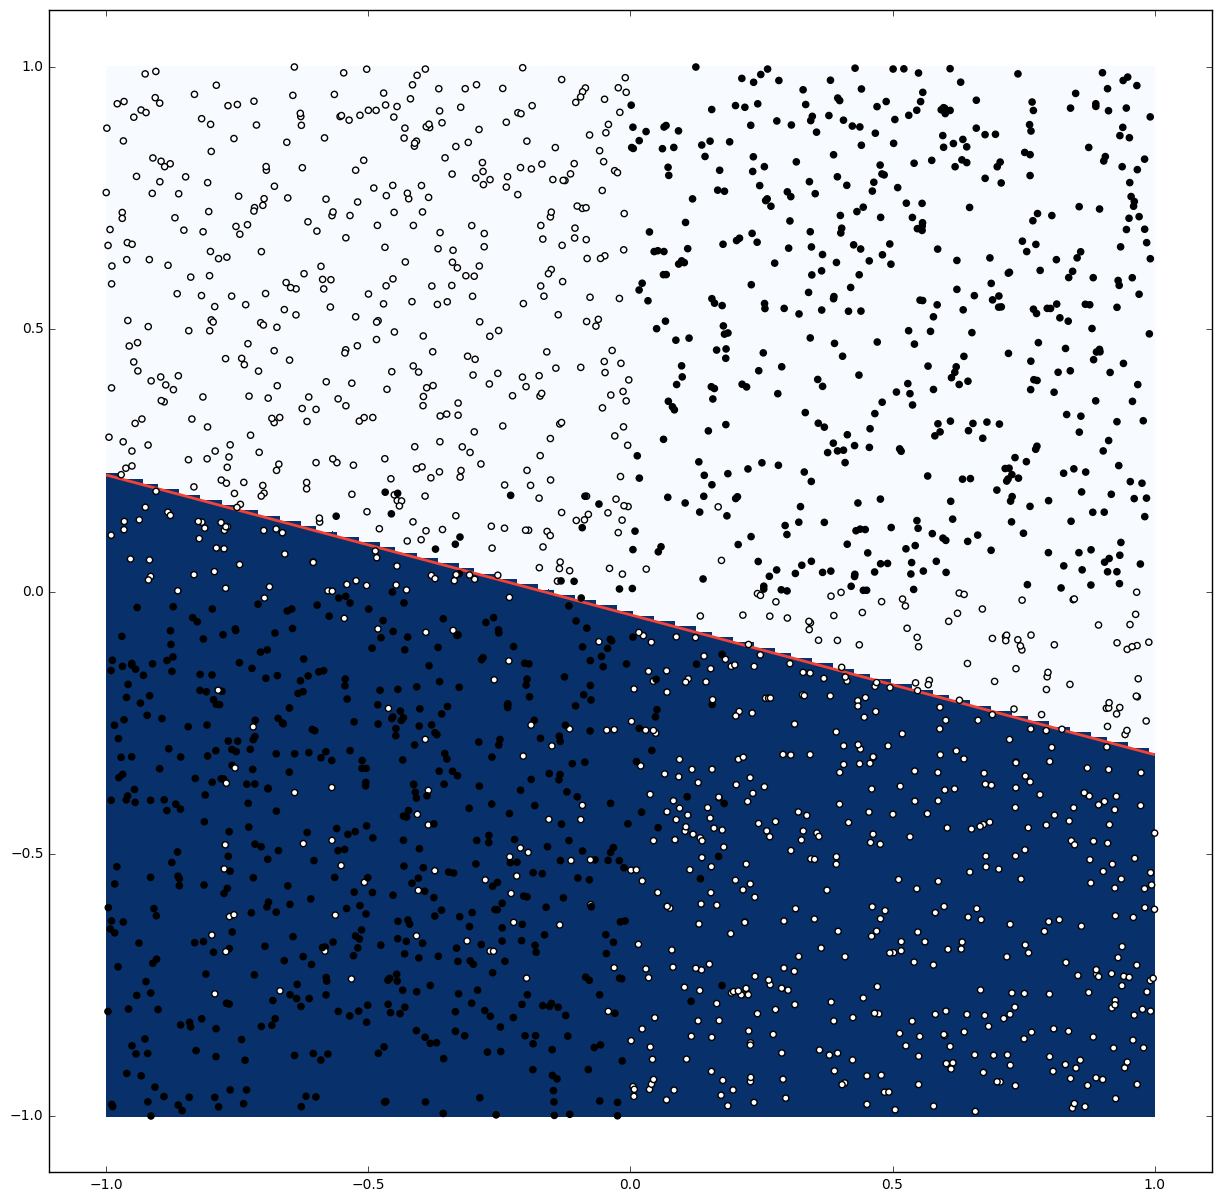

In [5]:
clf_linear = svm.LinearSVC(C = 30)
clf_linear.fit(X_train,Y_train)

get_model_performance(clf_linear,X_train,Y_train,X_test,Y_test,'svm')
plot_classifier(clf_linear,X_train,Y_train,X_test,Y_test,'svm')

<p>Para el entrenamiento de SVM lineal, se realizó el modelo con los datos de entrenamiento, para posteriormente observar el poder de predicción de este con los datos de prueba. Como fue predicho previamente, el modelo es incapaz de generar una categorización óptima siendo un SVM lineal, esto se observa tanto en el gráfico geneardo como en los datos de performance. </p>

<table style="width:40%">
    <tr>
        <th>Iteración</th>
        <th>Precisión</th>
        <th>Recall</th>
        <th>F1</th>
        
    </tr>
    <tr>
        <td>1</td>
        <td>0.56</td>
        <td>0.56</td>
         <td>0.56</td>
    </tr>
     <tr>
        <td>2</td>
        <td>0.34</td>
        <td>0.35</td>
         <td>0.33</td>
    </tr>
     <tr>
        <td>3</td>
        <td>0.44</td>
        <td>0.44</td>
         <td>0.44</td>
    </tr>
     <tr>
        <td>4</td>
        <td>0.24</td>
        <td>0.49</td>
         <td>0.42</td>
    </tr>
     <tr>
        <td>5</td>
        <td>0.76</td>
        <td>0.51</td>
         <td>0.35</td>
    </tr>
     <tr>
        <td>6</td>
        <td>0.26</td>
        <td>0.51</td>
         <td>0.54</td>
    </tr>
     <tr>
        <td>7</td>
        <td>0.61</td>
        <td>0.57</td>
         <td>0.51</td>
    </tr>
     <tr>
        <td>8</td>
        <td>0.51</td>
        <td>0.51</td>
         <td>0.31</td>
    </tr>
     <tr>
        <td>9</td>
        <td>0.31</td>
        <td>0.33</td>
         <td>0.38</td>
    </tr>
     <tr>
        <td>10</td>
        <td>0.76</td>
        <td>0.52</td>
         <td>0.38</td>
    </tr>
     <tr>
        <th>Promedio</th>
        <td>0.479</td>
        <td>0.479</td>
         <td>0.411</td>
    </tr>
</table>

<p>Los datos obtenidos nos indican que: menos de la mitad de los datos extraidos están correctamente clasificados y que de todos los datos correspondientes a una clase, menos de la mitad son extraidos correctamente. F1 Score sirve para complementar la observación previa, obteniendo un valor de 0.411 , relativamente pobre para una máquina de aprendizaje.</p> 

<h3>Análisis SVM Kernel Gaussiano </h3>

0.903636363636
0.972
             precision    recall  f1-score   support

         -1       0.98      0.97      0.97       489
          1       0.97      0.98      0.97       511

avg / total       0.97      0.97      0.97      1000



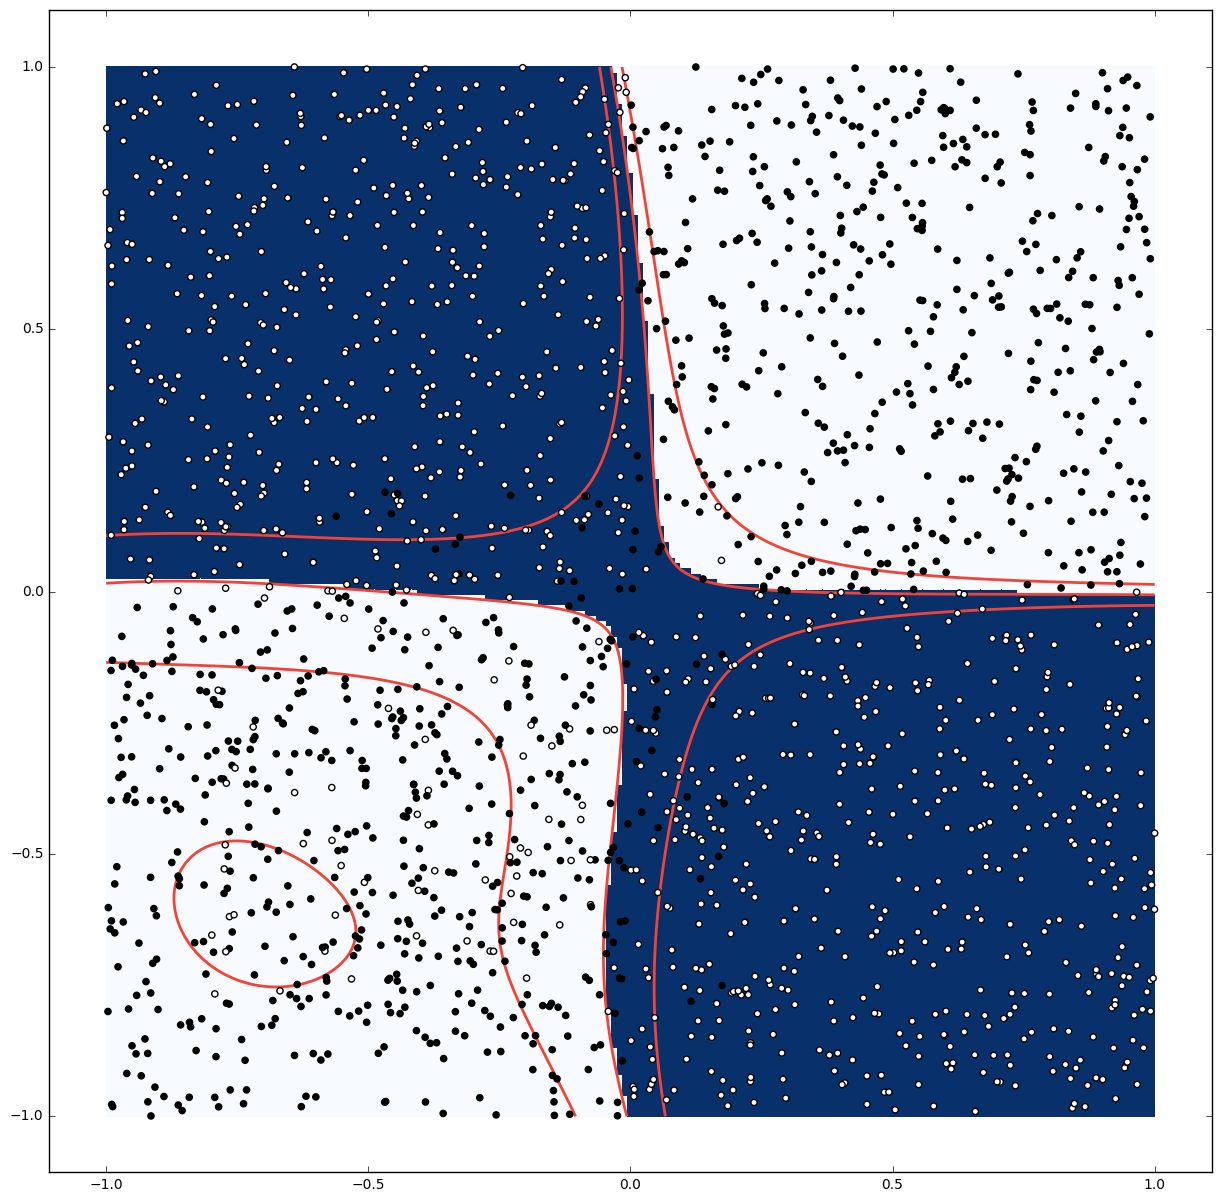

In [6]:
clf_kernel_rbf = SVC(C = 500, kernel = 'rbf')
clf_kernel_rbf.fit(X_train, Y_train)

get_model_performance(clf_kernel_rbf,X_train,Y_train,X_test,Y_test,'svm')
plot_classifier(clf_kernel_rbf,X_train,Y_train,X_test,Y_test,'svm')


<h3>Análisis SVM Kernel Polinomial </h3>



0.889090909091
0.954
             precision    recall  f1-score   support

         -1       0.99      0.91      0.95       489
          1       0.92      0.99      0.96       511

avg / total       0.96      0.95      0.95      1000



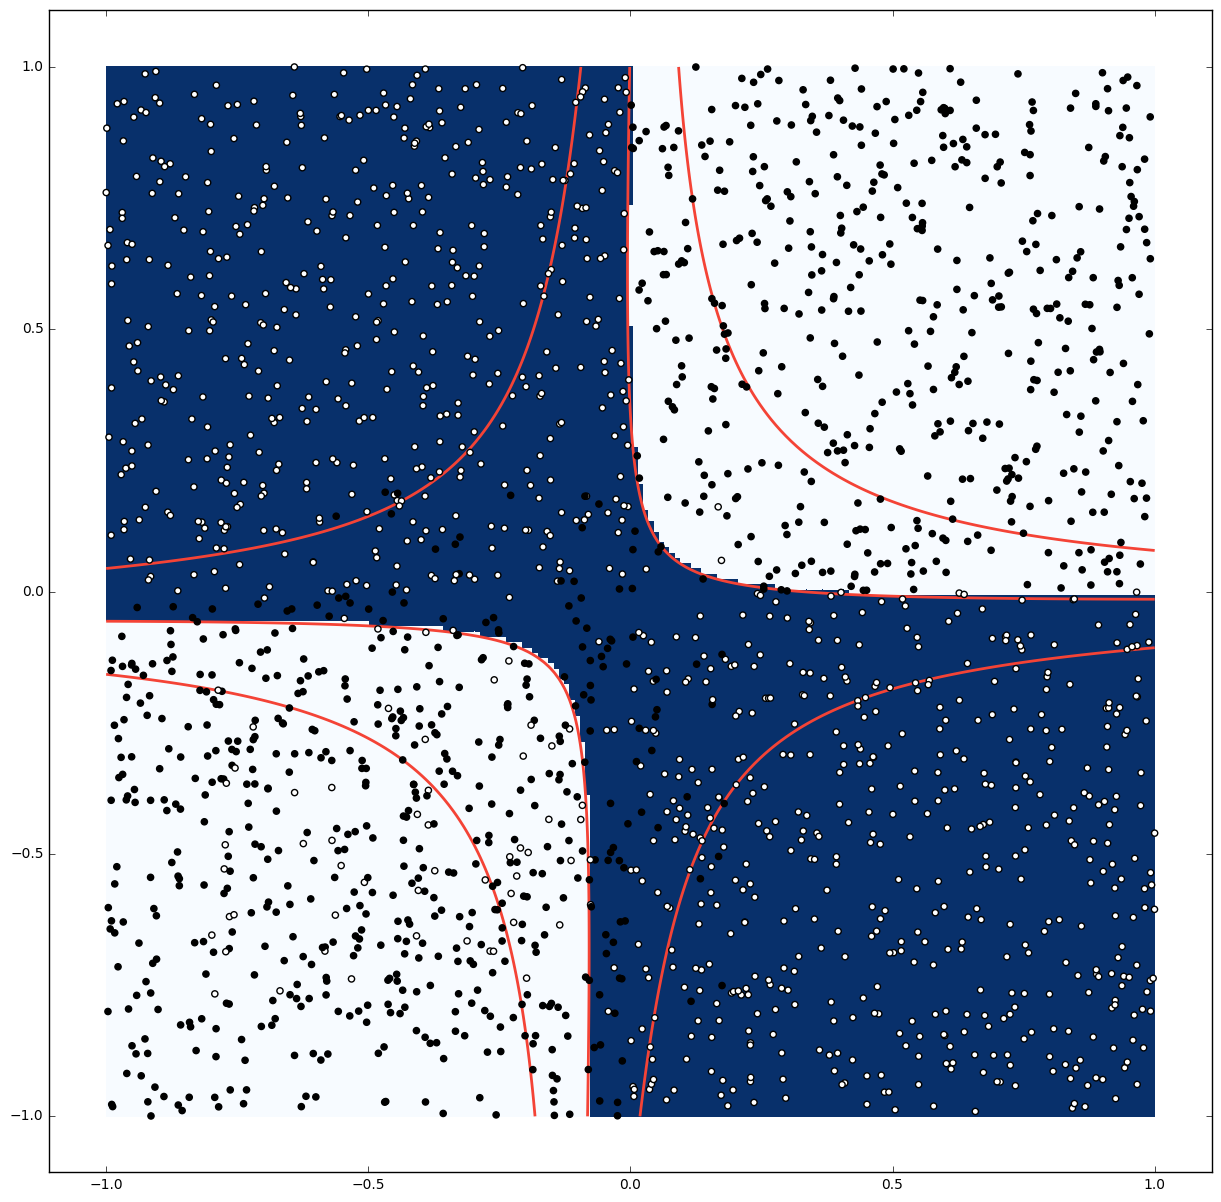

In [7]:
clf_kernel_poly = SVC(C = 10, kernel = 'poly', degree = 2, coef0 = 1)
clf_kernel_poly.fit(X_train, Y_train)

get_model_performance(clf_kernel_poly,X_train,Y_train,X_test,Y_test,'svm')
plot_classifier(clf_kernel_poly,X_train,Y_train,X_test,Y_test,'svm')

<h3> Análisis Red Neuronal </h3>

In [8]:
#Es necesario volver a generar el dataset con el parámetro svm = False
X_train,Y_train,X_test,Y_test = do_XOR(svm = False)

n_h = 1
model = Sequential()

model.add(Dense(1, input_dim=X_train.shape[1], init='uniform', activation='sigmoid'))
model.compile( optimizer = SGD( lr = 1 ), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit( X_train, Y_train, nb_epoch = 50, batch_size = 100, verbose = 1)
scores = model.evaluate(X_test, Y_test)
test_acc = scores[1]
scores = model.evaluate(X_train, Y_train)
train_acc = scores[1]


Epoch 1/50
1100/1100 [==============================] - 0s - loss: 0.6942 - acc: 0.4636     
Epoch 2/50
1100/1100 [==============================] - 0s - loss: 0.6921 - acc: 0.5045     
Epoch 3/50
1100/1100 [==============================] - 0s - loss: 0.6927 - acc: 0.5000     
Epoch 4/50
1100/1100 [==============================] - 0s - loss: 0.6925 - acc: 0.5591     
Epoch 5/50
1100/1100 [==============================] - 0s - loss: 0.6924 - acc: 0.5318     
Epoch 6/50
1100/1100 [==============================] - 0s - loss: 0.6928 - acc: 0.5291     
Epoch 7/50
1100/1100 [==============================] - 0s - loss: 0.6922 - acc: 0.5118     
Epoch 8/50
1100/1100 [==============================] - 0s - loss: 0.6916 - acc: 0.5427     
Epoch 9/50
1100/1100 [==============================] - 0s - loss: 0.6927 - acc: 0.5064     
Epoch 10/50
1100/1100 [==============================] - 0s - loss: 0.6927 - acc: 0.5127     
Epoch 11/50
1100/1100 [==============================] - 0s - loss: 0

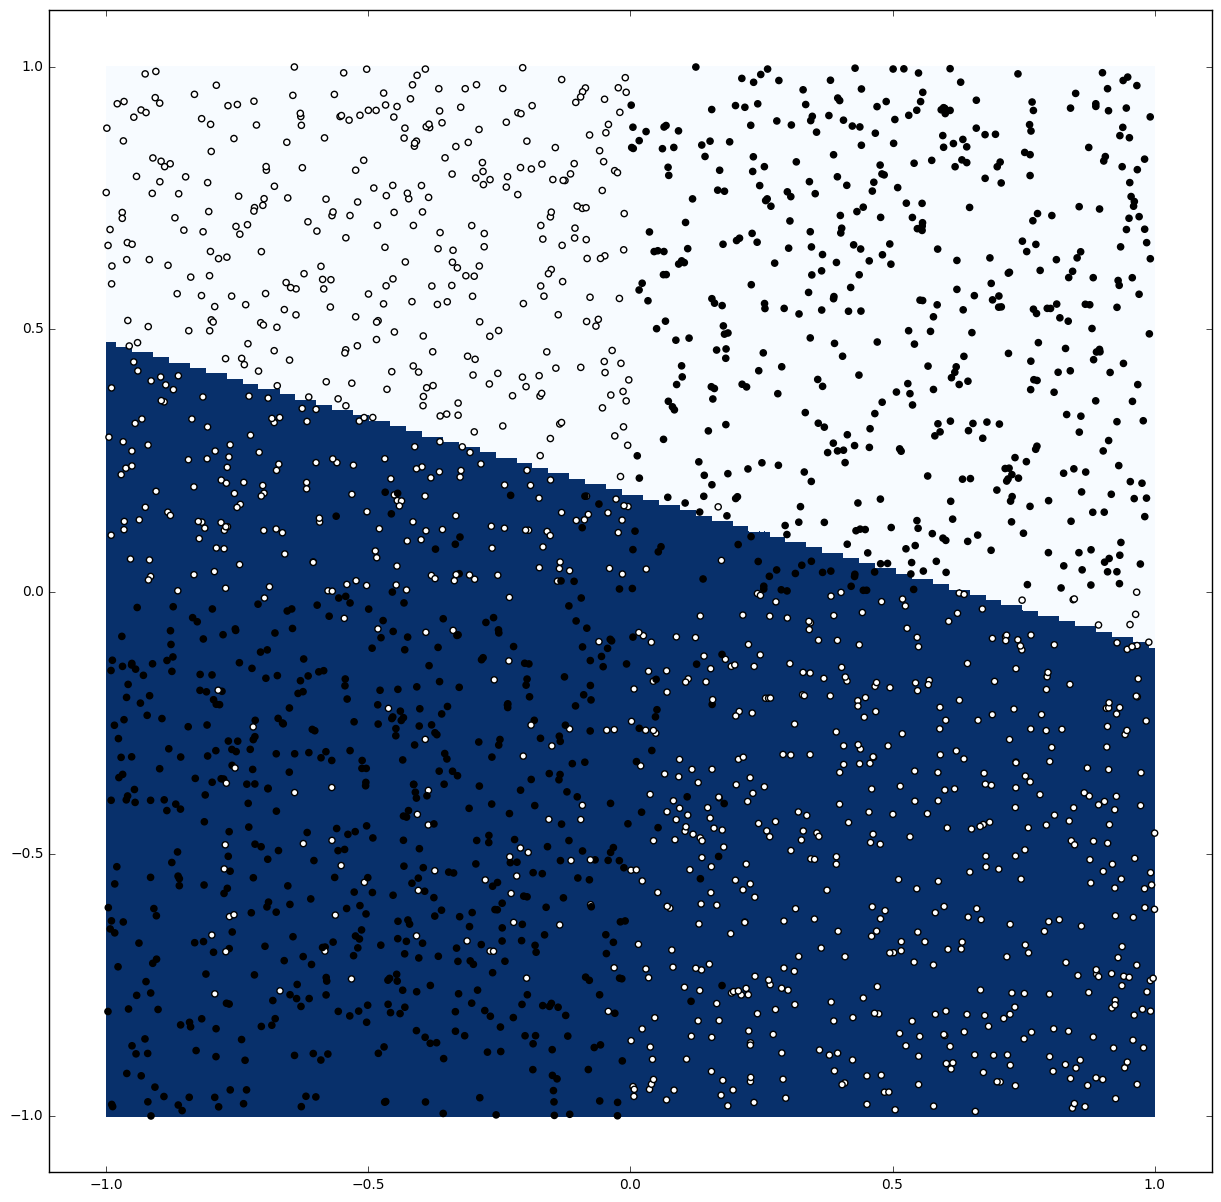

 Training Accuracy: 0.570909090692
 Test Accuracy: 0.559


In [9]:
plot_classifier(model,X_train,Y_train, X_test, Y_test, 'ann')
print " Training Accuracy: " + str(train_acc)
print " Test Accuracy: " + str(test_acc)

In [10]:
n_h = 32
model = Sequential()
model.add(Dense(n_h, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='sigmoid'))

model.compile( optimizer = SGD( lr = 1 ), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit( X_train, Y_train, nb_epoch = 50, batch_size = 100, verbose = 1)
model.fit( X_train, Y_train, nb_epoch = 50, batch_size = 100, verbose = 1)

scores = model.evaluate(X_train, Y_train)
train_acc = scores[1]

scores = model.evaluate(X_test, Y_test)
test_acc = scores[1]



Epoch 1/50
1100/1100 [==============================] - 0s - loss: 0.6925 - acc: 0.4982     
Epoch 2/50
1100/1100 [==============================] - 0s - loss: 0.6886 - acc: 0.5382     
Epoch 3/50
1100/1100 [==============================] - 0s - loss: 0.6778 - acc: 0.6891     
Epoch 4/50
1100/1100 [==============================] - 0s - loss: 0.6489 - acc: 0.7864     
Epoch 5/50
1100/1100 [==============================] - 0s - loss: 0.5825 - acc: 0.8427     
Epoch 6/50
1100/1100 [==============================] - 0s - loss: 0.4925 - acc: 0.8555     
Epoch 7/50
1100/1100 [==============================] - 0s - loss: 0.4184 - acc: 0.8700     
Epoch 8/50
1100/1100 [==============================] - 0s - loss: 0.3706 - acc: 0.8718     
Epoch 9/50
1100/1100 [==============================] - 0s - loss: 0.3476 - acc: 0.8736     
Epoch 10/50
1100/1100 [==============================] - 0s - loss: 0.3356 - acc: 0.8809     
Epoch 11/50
1100/1100 [==============================] - 0s - loss: 0

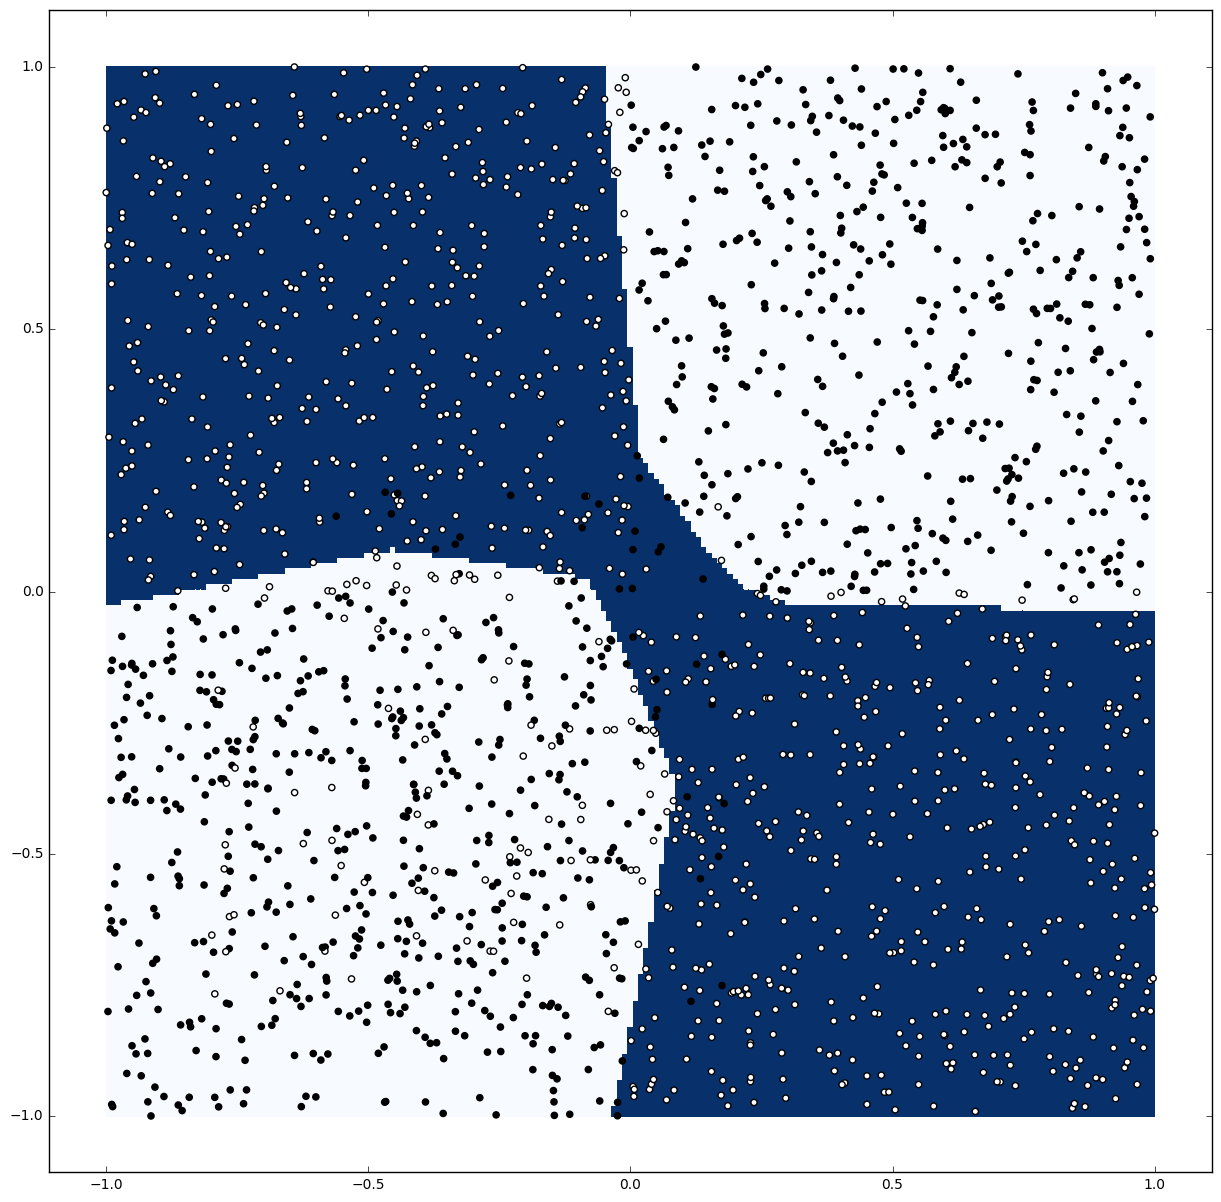

Train Accuraccy: 0.89
Test Accuraccy: 0.963


In [11]:
plot_classifier(model,X_train,Y_train, X_test, Y_test, 'ann')
print "Train Accuraccy: " + str(train_acc)
print "Test Accuraccy: " + str(test_acc)

<h3> Análisis Árbol Clasificador </h3>


0.541818181818
0.489
             precision    recall  f1-score   support

         -1       0.48      0.67      0.56       489
          1       0.50      0.32      0.39       511

avg / total       0.49      0.49      0.47      1000



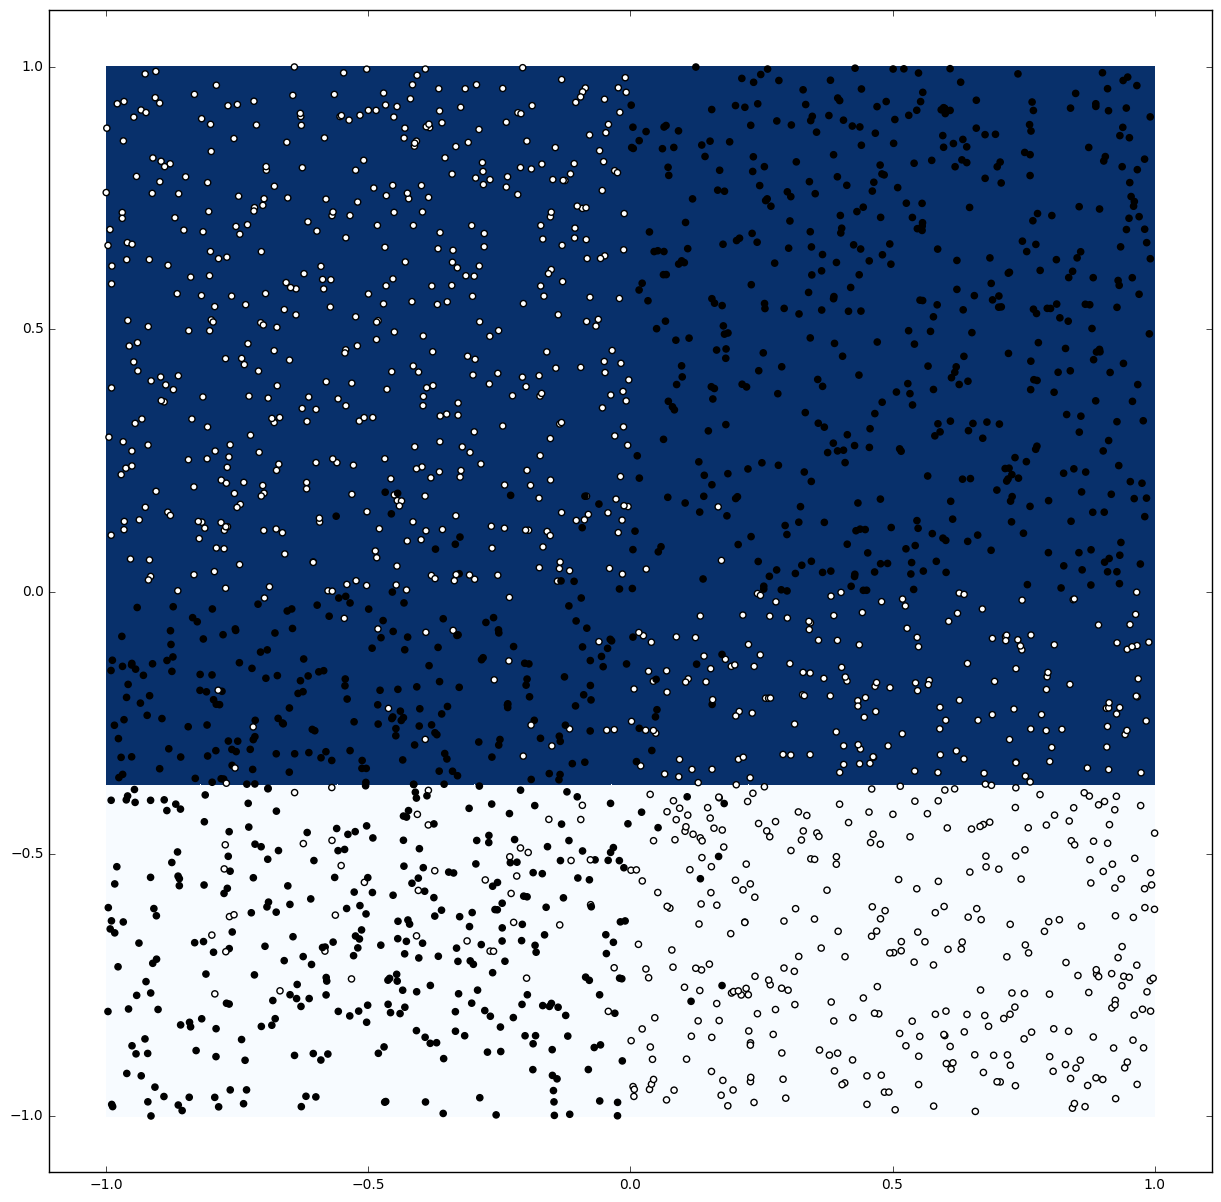

In [12]:
clf_tree = Tree ( criterion = 'gini', splitter = 'best', random_state = 0 , max_depth = 1)
clf_tree.fit( X_train , Y_train )

get_model_performance( clf_tree , X_train, Y_train, X_test, Y_test, 'tree')
plot_classifier( clf_tree , X_train , Y_train , X_test , Y_test , 'tree')


1.0
0.92
             precision    recall  f1-score   support

         -1       0.93      0.90      0.92       489
          1       0.91      0.94      0.92       511

avg / total       0.92      0.92      0.92      1000



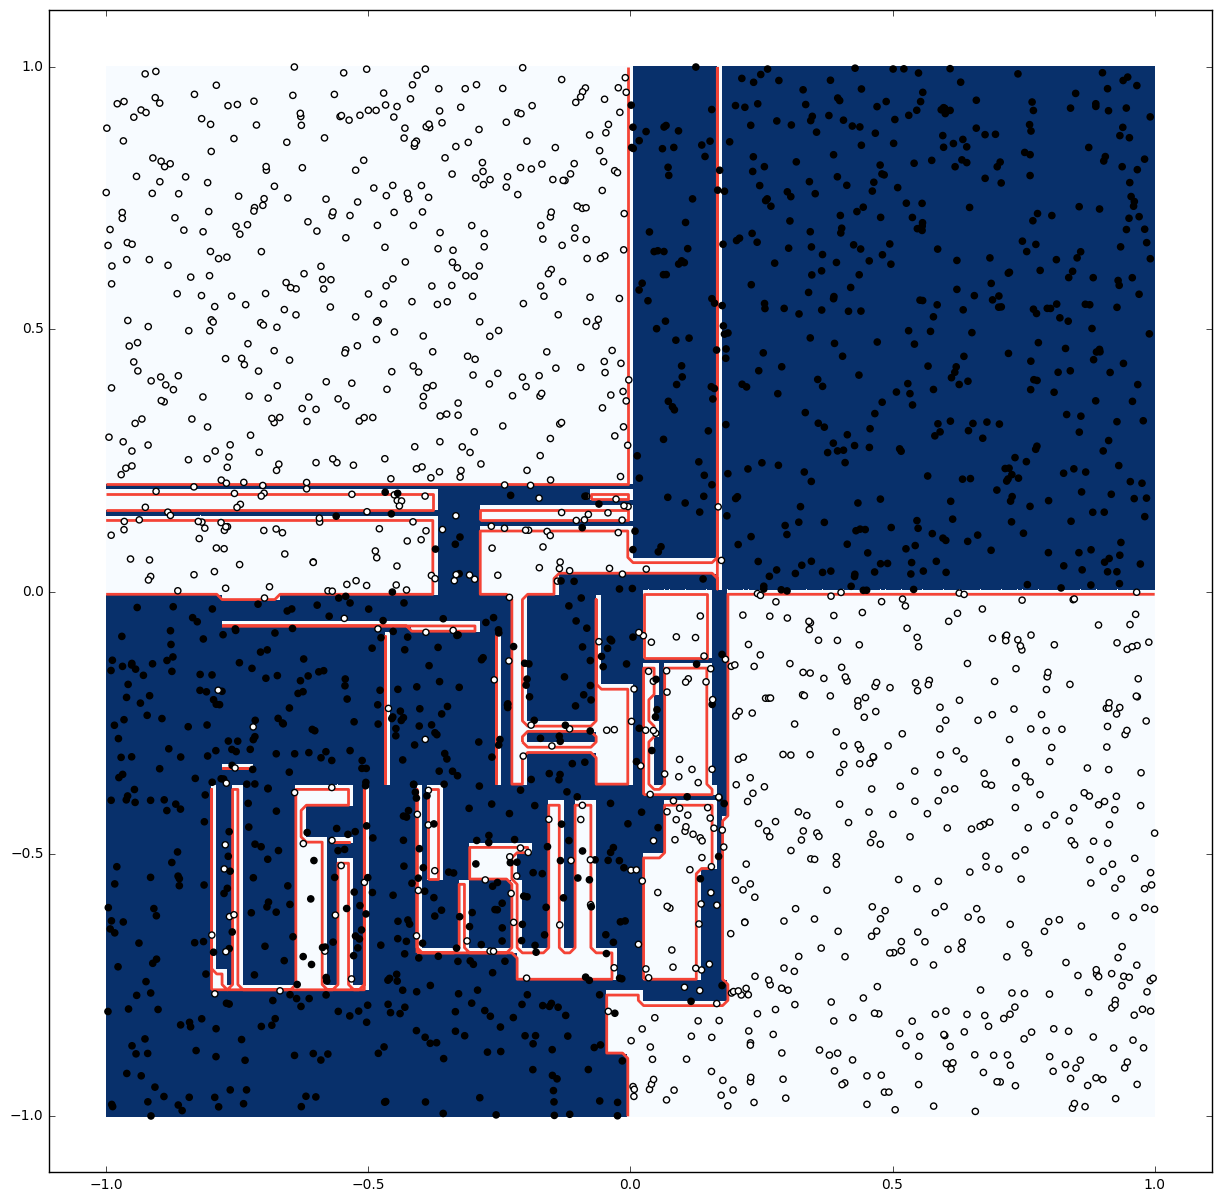

In [13]:
clf_tree = Tree ( criterion = 'gini', splitter = 'best', random_state = 0 , max_depth = 20)
clf_tree.fit( X_train , Y_train )

get_model_performance( clf_tree , X_train, Y_train, X_test, Y_test, 'tree')
plot_classifier( clf_tree , X_train , Y_train , X_test , Y_test , 'tree')

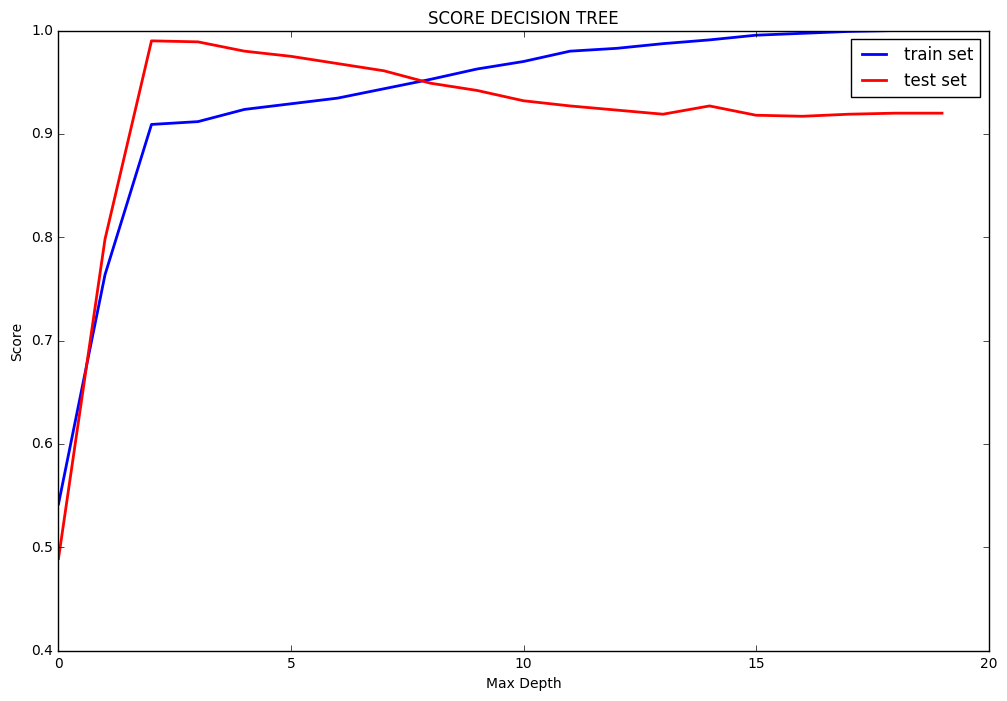

In [14]:
def get_train_set_treeplot(X_train, Y_train, X_test, Y_test):
    train_score = []
    test_score = []
    for i in range(1,21):
        clf_tree = Tree ( criterion = 'gini', splitter = 'best', random_state = 0 , max_depth = i)
        clf_tree.fit( X_train , Y_train )
        
        train_score.append(clf_tree.score(X_train,Y_train))
        test_score.append(clf_tree.score(X_test,Y_test))
        
    plt.figure(figsize=(12,8))  
    plt.plot(train_score,label="train set",linewidth="2")
    plt.plot(test_score, label="test set",color="red",linewidth="2")
    plt.title("SCORE DECISION TREE")
    plt.xlabel("Max Depth")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    
get_train_set_treeplot(X_train, Y_train, X_test, Y_test)       
        
        

<h2> PARTE 3 </h2>

In [15]:
from scipy.misc import imread
import cPickle as pickle
import numpy as np
import os
import random

from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

def unpickle(file):
   
   fo = open(file, 'rb')
   dict = pickle.load(fo)
   fo.close()
   return dict

def load_CIFAR_one(filename):
   with open(filename, 'rb') as f:
      datadict = pickle.load(f)
      X = datadict['data']
      Y = datadict['labels']
      return X, np.array(Y)

def load_CIFAR10(PATH):
   xs = []
   ys = []
   for b in range(1,6):
      f = os.path.join(PATH, 'data_batch_%d' % (b, ))
      X, Y = load_CIFAR_one(f)
      xs.append(X)
      ys.append(Y)
   Xtr = np.concatenate(xs)
   Ytr = np.concatenate(ys)
   del X, Y
   Xte, Yte = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
   
   i = random.randint(0, 40000)
   Xval = Xtr[i:(i+10000)]
   Yval = Ytr[i:(i+10000)]

   return Xtr, Ytr, Xte, Yte, Xval,Yval

In [16]:
def scale_data1(Xtr,Xte,Xval):
   return Xtr/255.0 ,Xte/255.0 ,Xval/255.0

def scale_data2(Xtr,Xte):
   scaler = StandardScaler()
   Xtr_scaled = scaler.fit_transform(Xtr[:20000])
   Xte_scaled = scaler.fit_transform(Xte)
   #Xval = scaler.fit_transform(Xval)
   return Xtr_scaled, Xte_scaled

def scaler_function(Xtr,Xte,scale=True):
   scaler = StandardScaler(with_std = scale).fit(Xtr[:22000])
   Xtr_scaled = scaler.transform(Xtr[:22000])
   Xte_scaled = scaler.transform(Xte)
   return Xtr_scaled, Xte_scaled

In [17]:
Xtr, Ytr, Xte, Yte, Xval, Yval = load_CIFAR10('.')

Xtr_scaled, Xte_scaled = scaler_function(Xtr,Xte)


/home/nacho/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nacho/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nacho/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [18]:
#SI USTED ES NACHO DELET THIS
Xtr,Xte = scaler_function(Xtr,Xte)
Ytr = to_categorical(Ytr[:22000])
Yte = to_categorical(Yte)


/home/nacho/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nacho/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nacho/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<h3> Implementación : Redes Neuronales </h3>

In [19]:
def neural_network_classifier(Xtr, Ytr, Xte, Yte, Xv, Yv):

    model = Sequential()
    model.add(Dense( 100, input_dim = Xtr.shape[1], init = 'uniform', activation = 'relu'))
    model.add( Dropout(0.1) )
    model.add(Dense(10, init = 'uniform', activation = 'softmax'))
    model.compile(optimizer = SGD( lr = 0.05), loss = 'binary_crossentropy', metrics = ['accuracy'] )
    model.fit(Xtr, Ytr, nb_epoch = 50, batch_size = 32, verbose = 1, validation_data = (Xte,Yte))
    scores = model.evaluate(Xte, Yte)
    test_acc = scores[1]
    
    print "Test Accuracy: " + str(test_acc)
    scores = model.evaluate(Xtr, Ytr)
    
    train_acc = scores[1]
    print "Train Accuracy: " + str(train_acc)
    
    val_acc = scores[1]
    print "Evaluate Accuracy: " + str(val_acc)

neural_network_classifier(Xtr, Ytr, Xte, Yte, Xval, Yval)

Train on 22000 samples, validate on 10000 samples
Epoch 1/50
22000/22000 [==============================] - 5s - loss: 0.2845 - acc: 0.9014 - val_loss: 0.2651 - val_acc: 0.9033
Epoch 2/50
22000/22000 [==============================] - 5s - loss: 0.2586 - acc: 0.9047 - val_loss: 0.2521 - val_acc: 0.9064
Epoch 3/50
22000/22000 [==============================] - 5s - loss: 0.2481 - acc: 0.9072 - val_loss: 0.2455 - val_acc: 0.9074
Epoch 4/50
22000/22000 [==============================] - 5s - loss: 0.2414 - acc: 0.9090 - val_loss: 0.2397 - val_acc: 0.9100
Epoch 5/50
22000/22000 [==============================] - 5s - loss: 0.2347 - acc: 0.9112 - val_loss: 0.2347 - val_acc: 0.9113
Epoch 6/50
22000/22000 [==============================] - 5s - loss: 0.2302 - acc: 0.9126 - val_loss: 0.2327 - val_acc: 0.9120
Epoch 7/50
22000/22000 [==============================] - 5s - loss: 0.2266 - acc: 0.9138 - val_loss: 0.2326 - val_acc: 0.9120
Epoch 8/50
22000/22000 [==============================] - 5s 

<h4>TEST ACCURACY: 0.909419999</h4>
<h4>TRAINING ACCURACY: 0.9610409</h4>
<h4>EVAL ACCURACY: 0.96104090</h4>

In [20]:
from top_level_features import hog_features
from top_level_features import color_histogram_hsv
from top_level_features import extract_features

In [21]:
Xtr, Ytr, Xte, Yte, Xval, Yval = load_CIFAR10(".")
features = extract_features(Xtr,[hog_features]) #extrae hog features
features = extract_features(Xtr,[color_histogram_hsv]) #extrae histogramas de color
features = extract_features(Xtr,[hog_features, color_histogram_hsv]) #extrae todo
print Xtr.shape
print features.shape

(50000, 32, 32, 3)
(50000, 32, 32, 3)
(50000, 32, 32, 3)
(50000, 3072)
(50000, 154)


<h3> Implementación SVM No Lineal </h3>



In [23]:
def NoLineal_SVM_classifier(Xtr, Ytr, Xte, Yte, Xv, Yv):
    clf_kernel_rbf = SVC(C = 500, kernel = 'rbf')
    clf_kernel_rbf.fit(Xtr, Ytr)

    #clf_kernel_poly = SVC(C = 10, kernel = 'poly', degree = 2, coef0 = 1)
    #clf_kernel_poly.fit(Xtr, Ytr)
    
    #training_kernel_score = clf_kernel_rbf.score(Xtr,Ytr)
    
    testing_kernel_score = clf_kernel_rbf.score(Xte,Yte)
    
    eval_kernel_score = clf_kernel_rbf.score(Xv,Yv)
    
    #training_poly_score = clf_kernel_poly.score(Xtr,Ytr)
    
    #testing_poly_score = clf_kernel_poly.score(Xte,Yte)
    
    #eval_poly_score = clf_kernel_poly.score(Xv,Yv)
    
    #print "Kernel Training Accuracy: " + str(training_kernel_score)
    
    print "Kernel Test Accuracy: " + str(testing_kernel_score)
    
    print "Kernel Eval Accuracy: " + str(eval_kernel_score)
    
    #print "Polynomial Training Accuracy: " + str(training_poly_score)
    
    #print "Polynomial Training Accuracy: " + str(testing_poly_score)
    
    #print "Polynomial Training Accuracy: " + str(eval_poly_score)
    
NoLineal_SVM_classifier(Xtr[:10000], Ytr[:10000], Xte[:10000], Yte[:10000], Xval[:10000], Yval[:10000])
    

Kernel Test Accuracy: 0.1
Kernel Eval Accuracy: 0.097


Kernel Training Accuracy: 1.0

Kernel Test Accuracy: 0.1
Kernel Eval Accuracy: 0.097